## Import Libraries and Functions

In [20]:
import pandas as pd
import numpy as np
import requests
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'jupyterlab'
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import chart_studio.plotly as py
import plotly.graph_objects as go
from tensorflow.python.keras.saving.hdf5_format import save_attributes_to_hdf5_group
import keras
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [2]:
BOOKS_OLD_TESTAMENT = [
'Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy', 'Joshua', 'Judges', 'Ruth',
'1 Samuel', '2 Samuel', '1 Kings', '2 Kings', '1 Chronicles', '2 Chronicles', 'Ezra', 'Nehemiah',
'Esther', 'Job', 'Psalms', 'Proverbs', 'Ecclesiastes', 'Song of Solomon', 'Isaiah', 'Jeremiah',
'Lamentations', 'Ezekiel', 'Daniel', 'Hosea', 'Joel', 'Amos', 'Obadiah', 'Jonah',
'Micah', 'Nahum', 'Habakkuk', 'Zephaniah', 'Haggai', 'Zechariah', 'Malachi'
]
BOOKS_NEW_TESTAMENT = [
'Matthew', 'Mark', 'Luke', 'John', 'Acts', 'Romans', '1 Corinthians', '2 Corinthians',
'Galatians', 'Ephesians', 'Philippians', 'Colossians', '1 Thessalonians', '2 Thessalonians', '1 Timothy', '2 Timothy',
'Titus', 'Philemon', 'Hebrews', 'James', '1 Peter', '2 Peter', '1 John', '2 John',
'3 John', 'Jude', 'Revelation'
]

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
bible_url = 'https://bereanbible.com/bsb.txt'

In [5]:
with open('./data/bereanbible.txt', 'r') as f:
    text = f.read()

In [6]:
response = requests.get(bible_url)
raw_bible = response.text

In [7]:
bible_list = raw_bible.splitlines()

In [8]:
bible_array = np.array([item.split('\t') for item in bible_list])

In [9]:
def printable_string(text):
    # string.translate(text, string.printable)
    # text = text.translate(str.maketrans('', '', string.printable))
    # filtered_string = (filter(lambda x: x in string.printable, text))
    filtered_string = ''.join(s for s in text if s in string.printable)
    return filtered_string


bible_array[:, 1] = np.array([printable_string(verse) for verse in bible_array[:, 1]])

In [10]:
bible_array[5, 1]

'And God said, Let there be light, and there was light.'

In [11]:
bible_array.shape

(31105, 2)

In [12]:
df = pd.DataFrame(bible_array[3:, :], columns=['reference','text'])

In [13]:
df.head()

,reference,text
0,Genesis 1:1,In the beginning God created the heavens and t...
1,Genesis 1:2,"Now the earth was formless and void, and darkn..."
2,Genesis 1:3,"And God said, Let there be light, and there wa..."
3,Genesis 1:4,"And God saw that the light was good, and He se..."
4,Genesis 1:5,"God called the light day, and the darkness He ..."


In [15]:
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    4. Remove words
    '''
    stemmer = WordNetLemmatizer()
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
    nopunc = [word.lower() for word in nopunc.split() if word not in stopwords.words('english')]
    return [stemmer.lemmatize(word) for word in nopunc]

In [16]:
tfidfconvert = TfidfVectorizer(analyzer=text_process).fit(bible_array[3:,1])
tfidf_text = tfidfconvert.transform(bible_array[3:,1])
df_vocab = pd.DataFrame(index=None,
                        data=zip(tfidfconvert.vocabulary_.keys(),
                                 tfidfconvert.vocabulary_.values()),
                        columns=['word', 'index']).sort_values('index')
tfidf_df = pd.DataFrame(csr_matrix.todense(tfidf_text), columns=df_vocab.word)

In [17]:
tfidf_df.shape

(31102, 13879)

In [18]:
tfidf_df.head()

word,a,aaron,abaddon,abagtha,abanah,abandon,abandoned,abandoning,abarim,abba,...,zophim,zorah,zorathites,zorites,zuar,zuph,zur,zuriel,zurishaddai,zuzites
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
tfidf_df.describe()

word,a,aaron,abaddon,abagtha,abanah,abandon,abandoned,abandoning,abarim,abba,...,zophim,zorah,zorathites,zorites,zuar,zuph,zur,zuriel,zurishaddai,zuzites
count,31102.000000,31102.000000,31102.000000,31102.000000,31102.000000,31102.000000,31102.000000,31102.000000,31102.000000,31102.000000,...,31102.000000,31102.000000,31102.000000,31102.000000,31102.000000,31102.000000,31102.000000,31102.000000,31102.000000,31102.000000
mean,0.006169,0.003101,0.000107,0.000010,0.000012,0.000281,0.000494,0.000012,0.000069,0.000047,...,0.000013,0.000134,0.000021,0.000013,0.000075,0.000034,0.000058,0.000015,0.000073,0.000011
std,0.036374,0.031076,0.007202,0.001721,0.002195,0.010292,0.013113,0.002193,0.005453,0.004834,...,0.002305,0.007612,0.002655,0.002319,0.006052,0.003485,0.004706,0.002618,0.005881,0.001914
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.434448,0.699957,0.567491,0.303476,0.387032,0.557637,0.610996,0.386763,0.486077,0.567843,...,0.406428,0.535301,0.337861,0.408977,0.622155,0.424458,0.466502,0.461751,0.601266,0.337628


In [20]:
pca_model = PCA(n_components=2)
pca_array = pca_model.fit_transform(tfidf_df)

In [21]:
pca_array.shape

(31102, 2)

In [22]:
df['pca_1'] = pca_array[:,0]
df['pca_2'] = pca_array[:,1]

In [16]:
def book_split(text):
    book = text.split(' ')
    return ' '.join(book[0:len(book)-1])


df['book'] = df['reference'].apply(book_split)
df['testament'] = df['book'].apply(lambda x: 'OT' if x in BOOKS_OLD_TESTAMENT else 'NT')

<AxesSubplot: xlabel='pca_1', ylabel='pca_2'>

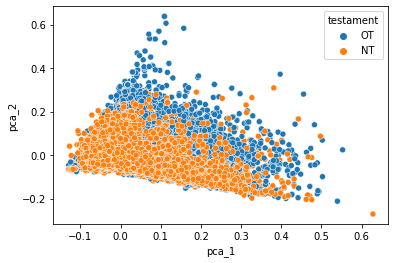

In [24]:
sns.scatterplot(data=df, x='pca_1', y='pca_2', hue='testament')

In [25]:
books_df = df[['pca_1', 'pca_2', 'book', 'testament']].groupby(['testament','book']).mean()

In [26]:
books_df = books_df.reset_index(level=[0,1])

<AxesSubplot: xlabel='pca_1', ylabel='pca_2'>

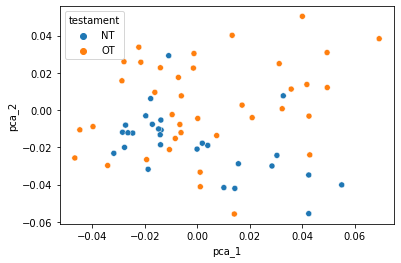

In [27]:
sns.scatterplot(data=books_df, x='pca_1', y='pca_2', hue='testament')

In [28]:
def scatter_text(x, y, text_column, data, title, xlabel, ylabel):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(data=data, x=x, y=y, size = 8, legend=False)
    # Add text besides each point
    for line in range(0,data.shape[0]):
         p1.text(data[x][line]+0.01, data[y][line], 
                 data[text_column][line], horizontalalignment='left', 
                 size='medium', color='black', weight='semibold')
    # Set title and axis labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return p1

<AxesSubplot: title={'center': 'books of the bible'}, xlabel='pca_1', ylabel='pca_2'>

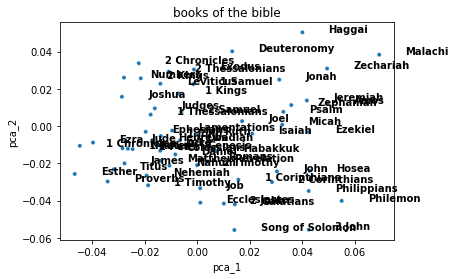

In [29]:
scatter_text(x='pca_1', y='pca_2',
             text_column='book', data=books_df,
             title='books of the bible',
             xlabel='pca_1', ylabel='pca_2')

## Try LLMs for Sentiment Analysis

### Initial Analysis Using the Book of Genesis

In [21]:
df_genesis = df.copy()
df_genesis = df_genesis[df_genesis['book'] == 'Genesis']

In [22]:
sentiment_pipeline = pipeline("sentiment-analysis")
text = list(df_genesis['text'])
genesis_output = sentiment_pipeline(text)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [23]:
df_genesis['sentiment'] = genesis_output
df_genesis.head()

,reference,text,book,testament,sentiment
0,Genesis 1:1,In the beginning God created the heavens and t...,Genesis,OT,"{'label': 'POSITIVE', 'score': 0.9981729984283..."
1,Genesis 1:2,"Now the earth was formless and void, and darkn...",Genesis,OT,"{'label': 'POSITIVE', 'score': 0.6871328353881..."
2,Genesis 1:3,"And God said, Let there be light, and there wa...",Genesis,OT,"{'label': 'POSITIVE', 'score': 0.971975564956665}"
3,Genesis 1:4,"And God saw that the light was good, and He se...",Genesis,OT,"{'label': 'POSITIVE', 'score': 0.9923180341720..."
4,Genesis 1:5,"God called the light day, and the darkness He ...",Genesis,OT,"{'label': 'NEGATIVE', 'score': 0.9347487092018..."


In [24]:
def sentiment_score_weight(sentiment):
    label = sentiment['label']
    # print(label)
    score = float(sentiment['score'])
    # print(score)
    label_value = 1 if label == 'POSITIVE' else -1
    weighted_score = label_value*score
    return weighted_score


df_genesis['weighted_score'] = df_genesis['sentiment'].apply(lambda x: sentiment_score_weight(sentiment=x))

In [25]:
def chapter_split(text):
    reference_list = text.split(' ')
    chapter_verse = reference_list[-1].split(':')
    return int(chapter_verse[0])

df_genesis['chapter'] = df['reference'].apply(chapter_split)

In [26]:
df_genesis.head()

,reference,text,book,testament,sentiment,weighted_score,chapter
0,Genesis 1:1,In the beginning God created the heavens and t...,Genesis,OT,"{'label': 'POSITIVE', 'score': 0.9981729984283...",0.998173,1
1,Genesis 1:2,"Now the earth was formless and void, and darkn...",Genesis,OT,"{'label': 'POSITIVE', 'score': 0.6871328353881...",0.687133,1
2,Genesis 1:3,"And God said, Let there be light, and there wa...",Genesis,OT,"{'label': 'POSITIVE', 'score': 0.971975564956665}",0.971976,1
3,Genesis 1:4,"And God saw that the light was good, and He se...",Genesis,OT,"{'label': 'POSITIVE', 'score': 0.9923180341720...",0.992318,1
4,Genesis 1:5,"God called the light day, and the darkness He ...",Genesis,OT,"{'label': 'NEGATIVE', 'score': 0.9347487092018...",-0.934749,1


In [27]:
df_genesis_chapters = df_genesis[['chapter', 'weighted_score']].groupby(['chapter']).mean()
df_genesis_chapters = df_genesis_chapters.reset_index(level=0)
df_genesis_chapters.head()

,chapter,weighted_score
0,1,0.535815
1,2,0.393337
2,3,0.181933
3,4,0.207043
4,5,0.371141


<AxesSubplot: xlabel='chapter', ylabel='weighted_score'>

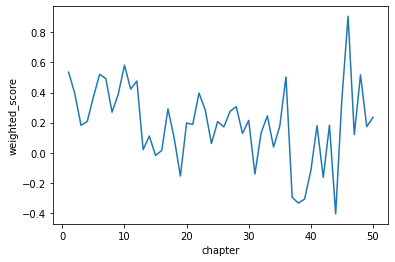

In [28]:
sns.lineplot(data = df_genesis_chapters, x='chapter', y='weighted_score')

<AxesSubplot: xlabel='chapter', ylabel='weighted_score'>

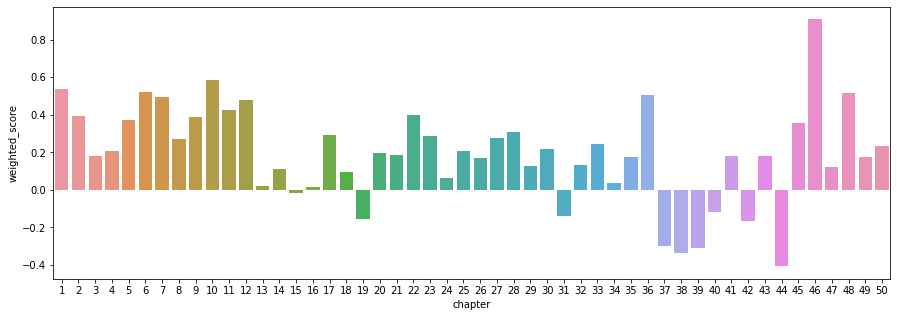

In [37]:
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(ax=ax, data = df_genesis_chapters, x='chapter', y='weighted_score')

In [29]:
# fig = go.Figure(go.Line(x=df_genesis_chapters.chapter, y=df_genesis_chapters.weighted_score))
# data = [go.Bar(x=df_genesis_chapters.chapter,
#             y=df_genesis_chapters.weighted_score)]

# py.iplot(data, filename='jupyter-basic_line')

# fig = px.line(df_genesis_chapters, x="chapter", y="weighted_score", title='Life expectancy in Canada')
# fig.show()